In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

Created WidebandSignal with 1.0 MHz total bandwidth and 10000 samples per step


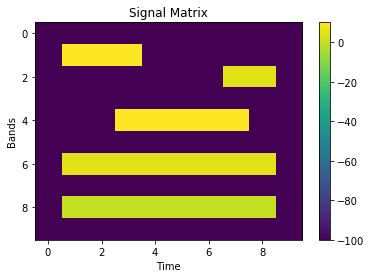

In [55]:
length = .1  # in seconds

wbs = ss.WidebandSignal(t_sec=length, num_bands=10, num_steps=10)

# You create the matrix with the time axis being vertical and the bands horizontal
# Most of the plots later on will rotate the matrix 90 degree right
mat = np.array([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100,    0, -100,    5, -100, -100, -100, -100,   10, -100],
                [-100,    0, -100,    5, -100, -100, -100, -100,   10, -100],
                [-100,    0, -100,    5, -100,   10, -100, -100,   10, -100],
                [-100,    0, -100,    5, -100,   10, -100, -100, -100, -100],
                [-100,    0, -100,    5, -100,   10, -100, -100, -100, -100],
                [-100,    0, -100,    5, -100,   10, -100, -100, -100, -100],
                [-100,    0, -100,    5, -100,   10, -100,    5, -100, -100],
                [-100,    0, -100,    5, -100, -100, -100,    5, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

# Plot the matrix
plt.imshow(np.rot90(mat, 1), aspect='auto')
plt.title("Signal Matrix")
plt.xlabel("Time")
plt.ylabel("Bands")
plt.colorbar()
plt.show()

sig, sample_freq = wbs.get_signal(mat)

noise_strength = 0.0  # in dB
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(dB=10.)

assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

both = sig + noise

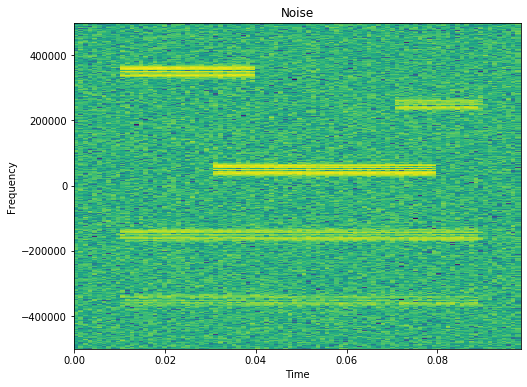

In [64]:
# Plot the resulting signals using our stft
nfft = 1024

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Noise")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

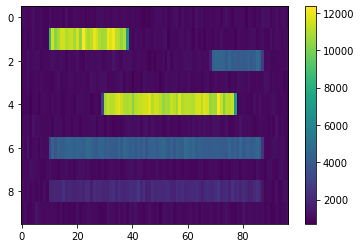

Threshold: 1099.91043


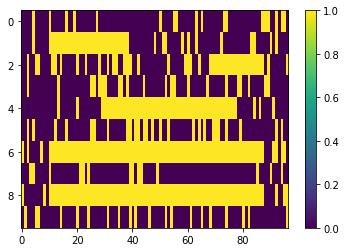

0.566349895783538

In [109]:
# Apply simple frequency energy detector
sft = ss.Stft(n=nfft,
              window='box')  # using box window here (instead of flattop)
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

fed = ss.FreqEnergyDetector(num_bands=10,
                            f_sample=sample_freq,
                            fft_len=1024,
                            freqs=f)

res = []
for i in range(len(x[0])):
    res.append(fed.detect(x[:, i]))
res = np.array(res)

plt.imshow(np.rot90(res), aspect='auto')
plt.colorbar()
plt.show()

thr = ss.chi2_stats.get_thr(
    noise_power=ss.util.dB_to_factor_power(noise_strength), pfa=0.01, n=1024)
# thr = 12000
print('Threshold: %10.5f' % (thr))

# Apply threshold to matrix
res = (res > thr) * np.full_like(res, 1.)

plt.imshow(np.rot90(res), aspect='auto')
plt.colorbar()
plt.show()

signal_power_fac = ss.util.dB_to_factor_power(0.)
noise_power_fac = ss.util.dB_to_factor_power(10.)
ss.chi2_stats.get_pd(noise_power=noise_power_fac, signal_power=signal_power_fac, thr=thr, n=1024//10)